In [1]:
import numpy as np 
import os
import segmentation_models as sm
import tensorflow as tf
import cv2
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
from glob import glob

Segmentation Models: using `keras` framework.


In [2]:
images = sorted(glob(os.path.join("./data/", "images", "*.png")))
masks = sorted(glob(os.path.join("./data/", "masks", "*.png")))


In [3]:
images

['./data/images\\1.png',
 './data/images\\10.png',
 './data/images\\100.png',
 './data/images\\1000.png',
 './data/images\\1001.png',
 './data/images\\1002.png',
 './data/images\\1003.png',
 './data/images\\1004.png',
 './data/images\\1005.png',
 './data/images\\1006.png',
 './data/images\\1007.png',
 './data/images\\1008.png',
 './data/images\\1009.png',
 './data/images\\101.png',
 './data/images\\1010.png',
 './data/images\\1011.png',
 './data/images\\1012.png',
 './data/images\\1013.png',
 './data/images\\1014.png',
 './data/images\\1015.png',
 './data/images\\1016.png',
 './data/images\\1017.png',
 './data/images\\1018.png',
 './data/images\\1019.png',
 './data/images\\102.png',
 './data/images\\1020.png',
 './data/images\\1021.png',
 './data/images\\1022.png',
 './data/images\\1023.png',
 './data/images\\1024.png',
 './data/images\\1025.png',
 './data/images\\1026.png',
 './data/images\\1027.png',
 './data/images\\1028.png',
 './data/images\\1029.png',
 './data/images\\103.png',
 

In [4]:
images[0]

'./data/images\\1.png'

# **PREPROCESSING**

In [5]:
input_images_size = 256
channel = 1

In [6]:
def load_image(img_path):
   
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2

    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
  
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
 
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img
        
def preprocess(img):
 
    img = img/255.0
    return img

def inverse_preprocess(img):

    img = img*255
    return img

def load_data(img_path, msk_path):
    
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)

    return img, msk

def load_batch(images, masks):
    
    batch_x = []
    batch_y = []
    for i, m in zip(images, masks):
        img, msk = load_data(i, m)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y)

C:\Users\praja\AppData\Local\Temp\ipykernel_16176\2567437596.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 252.0 (256, 256)


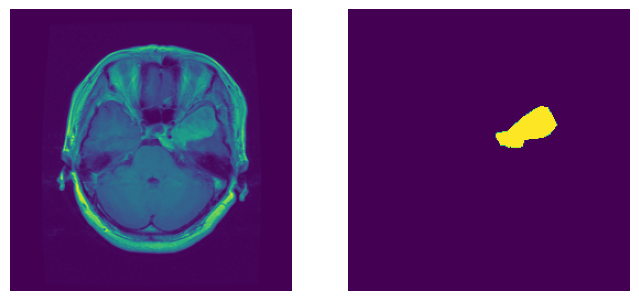

0.0 244.0 (256, 256)


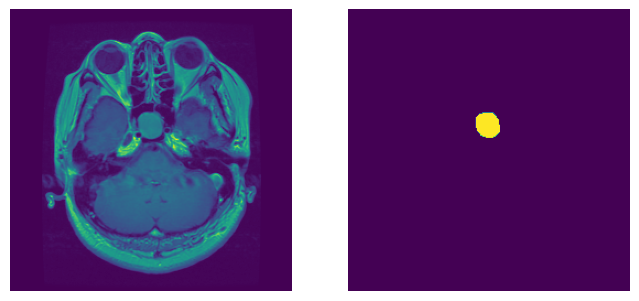

0.0 249.75 (256, 256)


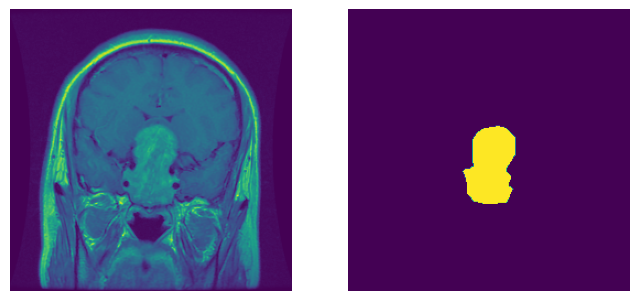

In [7]:
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(msk[:, :])
    plt.show()

In [8]:
images = np.array(images)
masks = np.array(masks)

# **MODEL CREATION & TRAINING**

In [10]:
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
LR = 0.00001
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size,
                             input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  3136        ['zero_padding2d[0][0]']   

In [12]:
batch_size = 4
history = {"epoch": []}
for e in range(50):
    print("epoch:",e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [],
                   "IOU": [],
                   "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = bs+batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
         "IOU", np.round(np.mean(temp_history["IOU"]), 4),
         "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)    
model.save_weights("brain_tumor_segmentation")

epoch: 0 > 

C:\Users\akash\AppData\Local\Temp\ipykernel_5748\2567437596.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


loss 1.0185 IOU 0.108 F-Score 0.1782
epoch: 1 > loss 0.9777 IOU 0.2343 F-Score 0.3554
epoch: 2 > loss 0.9328 IOU 0.336 F-Score 0.4784
epoch: 3 > loss 0.8661 IOU 0.4558 F-Score 0.605
epoch: 4 > loss 0.7829 IOU 0.5446 F-Score 0.6888
epoch: 5 > loss 0.6944 IOU 0.6078 F-Score 0.7429
epoch: 6 > loss 0.6064 IOU 0.661 F-Score 0.7851
epoch: 7 > loss 0.5156 IOU 0.7055 F-Score 0.8195
epoch: 8 > loss 0.4284 IOU 0.7396 F-Score 0.8436
epoch: 9 > loss 0.3508 IOU 0.76 F-Score 0.8582
epoch: 10 > loss 0.2842 IOU 0.7801 F-Score 0.8719
epoch: 11 > loss 0.2337 IOU 0.7959 F-Score 0.8824
epoch: 12 > loss 0.1973 IOU 0.8076 F-Score 0.8898
epoch: 13 > loss 0.1694 IOU 0.8179 F-Score 0.8966
epoch: 14 > loss 0.1472 IOU 0.8289 F-Score 0.9037
epoch: 15 > loss 0.1303 IOU 0.8385 F-Score 0.9096
epoch: 16 > loss 0.1189 IOU 0.8435 F-Score 0.9128
epoch: 17 > loss 0.1105 IOU 0.8471 F-Score 0.9152
epoch: 18 > loss 0.1024 IOU 0.853 F-Score 0.9187
epoch: 19 > loss 0.0955 IOU 0.8589 F-Score 0.9223
epoch: 20 > loss 0.0888 IOU 

In [ ]:
model.save("model.h5")

## FOR LOADING PRE-TRAINED MODEL ***(OPTIONAL)***

In [11]:
tf.keras.utils.get_custom_objects()['dice_loss_plus_1binary_focal_loss'] = dice_loss + (1 * focal_loss)
tf.keras.utils.get_custom_objects()['iou_score'] = sm.metrics.IOUScore(threshold=0.5)
tf.keras.utils.get_custom_objects()['f1-score'] = sm.metrics.FScore(threshold=0.5)


In [12]:
from keras.models import load_model

model = load_model("./Brain_0.95.h5")

# **TESTING**

In [13]:
import cv2

def color_overlay(img, mask, alpha=0.5):
    mask = mask > 0.87

    transparency_mask = np.zeros_like(img, dtype=np.uint8)
    transparency_mask[mask] = int(215 * alpha)

    color_image = np.zeros_like(img,dtype=np.uint8)
    color_image[..., 0] = 0 if mask.any() else 255  
    color_image[..., 1] = 0  
    color_image[..., 2] = 255 if not mask.any() else 0 

    img = img.astype(np.uint8)
    output = cv2.addWeighted(img, 0.05, color_image, 0.95, 0)
    output = cv2.add(output, transparency_mask)

    return output


0.0 241.0 (256, 256)
(256, 256)
1/1 [==============================] - ETA: 0s

C:\Users\praja\AppData\Local\Temp\ipykernel_16176\2567437596.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


1/1 [==============================] - 0s 146ms/step


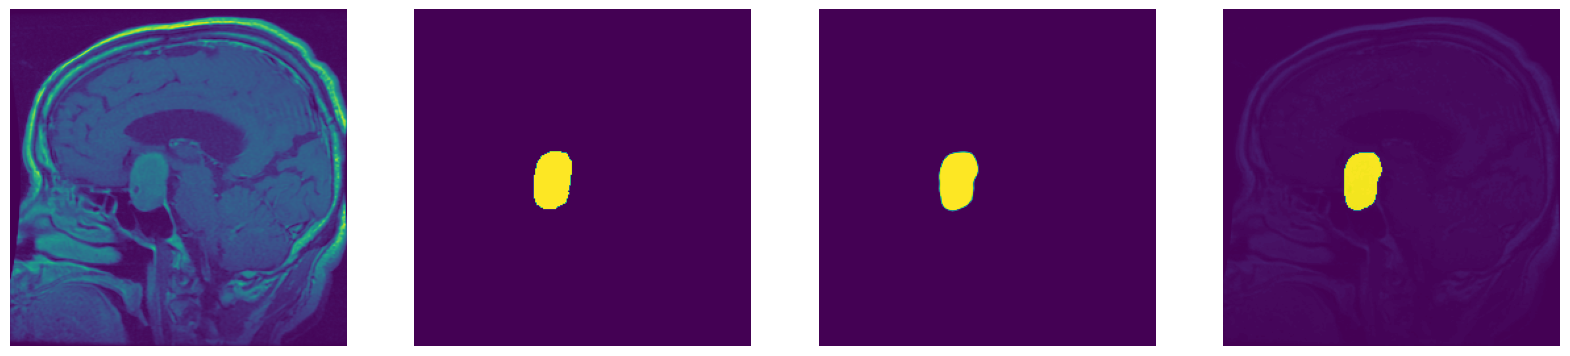

0.0 241.0 (256, 256)
(256, 256)
1/1 [==============================] - 0s 172ms/step


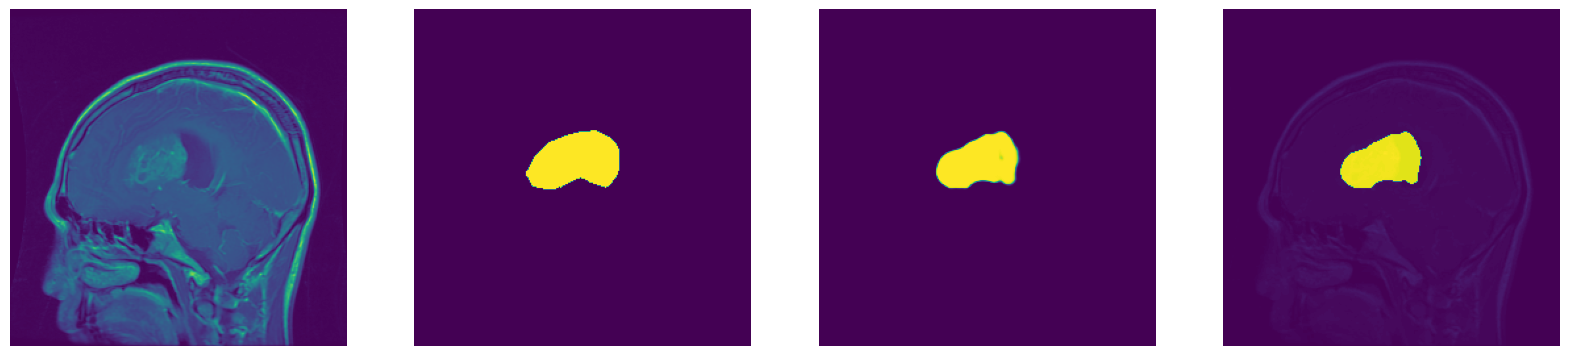

0.0 252.75 (256, 256)
(256, 256)
1/1 [==============================] - 0s 148ms/step


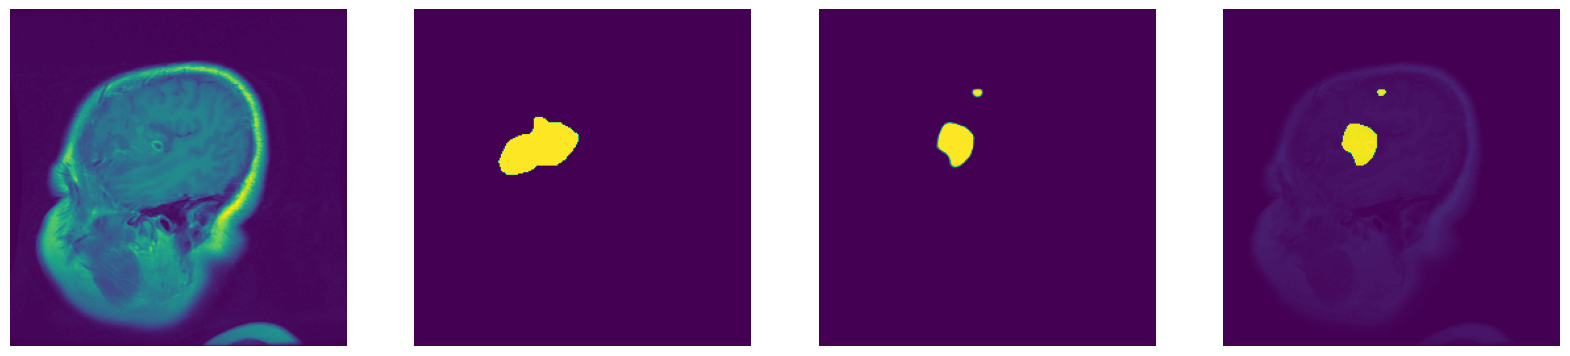

In [18]:
import random

image_indices = list(range(len(images)))

random_indices = random.sample(image_indices, 3)
for i in random_indices:
    indx = i
    img, msk = load_data(images[indx], masks[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)
    
    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]
    overlay = color_overlay(img, pred[:, :, 0], alpha=0.5)

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 4, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 4, 2)
    plt.axis("off")
    plt.imshow(msk)
    plt.subplot(1, 4, 3)
    plt.axis("off")
    plt.imshow(pred[:, :,0])
    plt.subplot(1, 4, 4)
    plt.axis("off")
    plt.imshow(overlay)
    plt.show()

## ***PLOTTING***

In [ ]:
avg_loss=[]
avg_acc=[]
avg_IOU=[]

for i in history["epoch"]:
    avg_loss.append(np.average(i["loss"]))
    avg_acc.append(np.average(i["F-Score"]))
    avg_IOU.append(np.average(i["IOU"]))

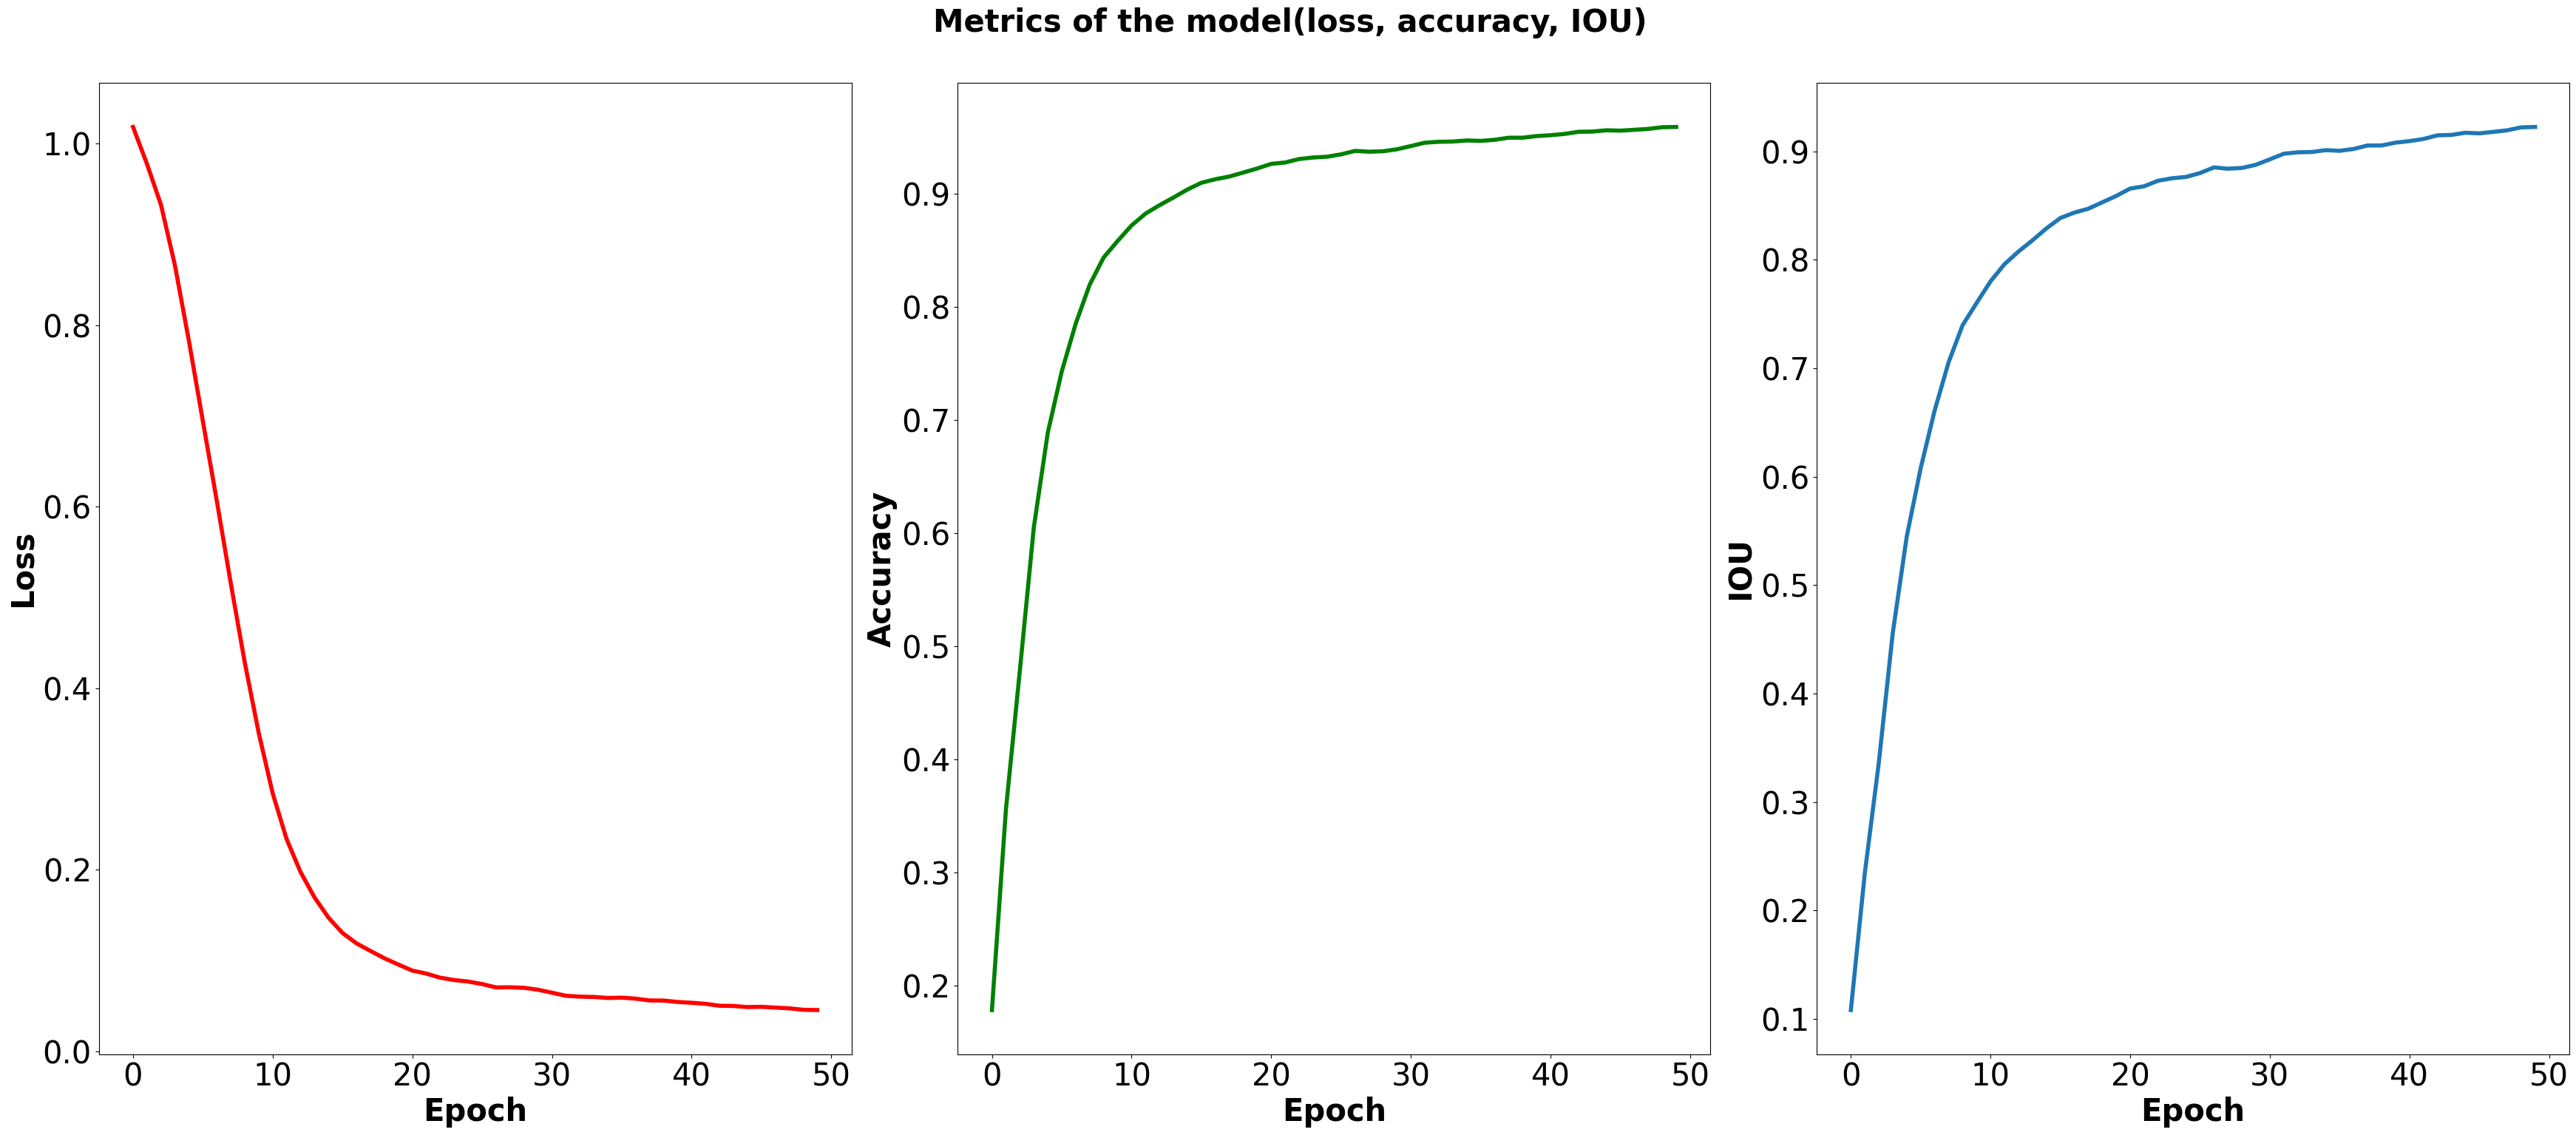

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(35, 15))
fig.suptitle("Metrics of the model(loss, accuracy, IOU)",fontsize=30,fontweight='bold',y=1.02)
axes[0].set_xlabel("Epoch",fontsize=30,fontweight='bold')
axes[0].set_ylabel("Loss",fontsize=30,fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[0].plot(range(0,len(avg_loss)),avg_loss,color="red",linewidth=4.0)
axes[1].set_xlabel("Epoch",fontsize=30,fontweight='bold')
axes[1].set_ylabel("Accuracy",fontsize=30,fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=30)
axes[1].plot(range(0,len(avg_acc)),avg_acc,color="green",linewidth=4.0)
axes[2].set_xlabel("Epoch",fontsize=30,fontweight='bold')
axes[2].set_ylabel("IOU",fontsize=30,fontweight='bold')
axes[2].tick_params(axis='both', which='major', labelsize=30)
axes[2].plot(range(0,len(avg_IOU)),avg_IOU,linewidth=4.0)
plt.tight_layout()
plt.show()

In [19]:
img =cv2.imread("BRAIN-TUMOUR3.jpg", 0)
img = cv2.resize(img, (input_images_size, input_images_size))
img2 = preprocess(img)
pred = model.predict(np.array([img2]))
pred = pred[0]
color_overlay_pred = color_overlay(img, pred[:, :, 0], alpha=0.5)

1/1 [==============================] - 0s 152ms/step


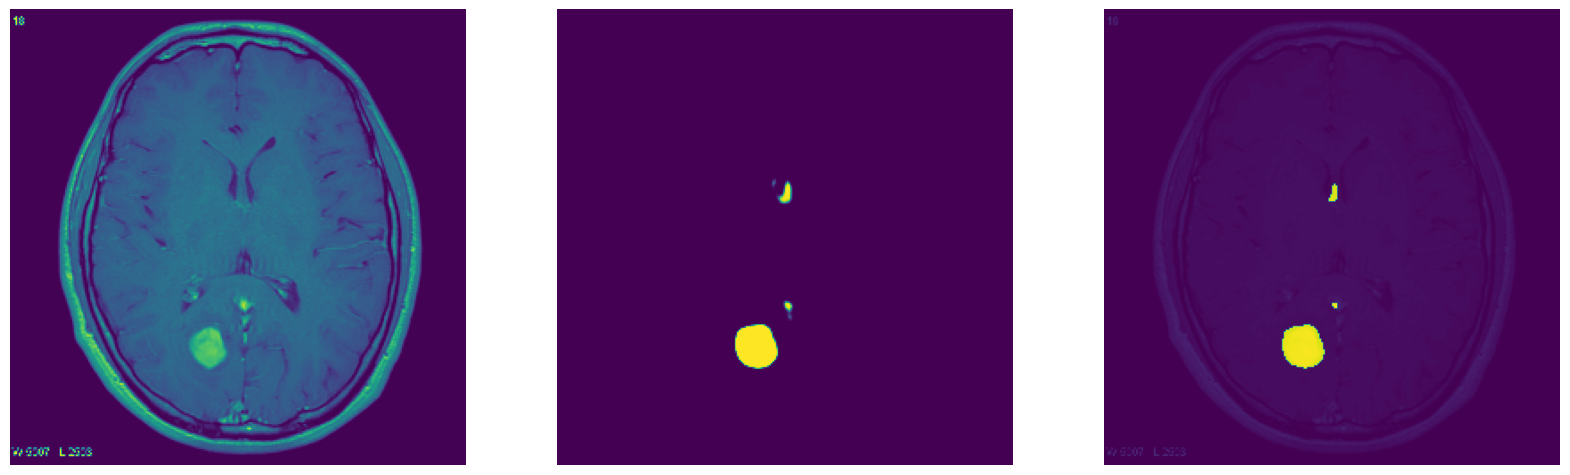

In [21]:
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img)
fig.add_subplot(1, 3, 2)
plt.axis("off")
plt.imshow(pred[:, :, 0])
fig.add_subplot(1, 3, 3)
plt.axis("off")
plt.imshow(color_overlay_pred)
plt.show()
